<h1 align="center">Building a Regression Model in PyTorch</h1>

Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro

Este tutorial está baseado no [Machine Learning Mastery - PhD.:Jason Brownlee](https://machinelearningmastery.com/building-a-regression-model-in-pytorch/?utm_source=drip&utm_medium=email&utm_campaign=Use+PyTorch+deep+learning+models+with+scikit-learn&utm_content=Use+PyTorch+deep+learning+models+with+scikit-learn):



Depois de reproduzir este tutorial, você haverá aprendido os seguintes pontos:

* Como carregar dados do `scikit-learn` e adaptá-los para modelos `PyTorch`

* Como criar uma rede neural para problema de regressão usando `PyTorch`

* Como melhorar o desempenho do modelo com técnicas de preparação de dados

# Descrição do Dataset

O conjunto de dados que você usará neste tutorial é o [conjunto de dados de habitação da Califórnia](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset).  


Você pode obter o conjunto de dados do scikit-learn, que por sua vez, é baixado da Internet em tempo real:

In [7]:
from sklearn.datasets import fetch_california_housing
 
data = fetch_california_housing()

print(data.feature_names)
 
X, y = data.data, data.target

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [8]:
import pandas as pd

X_df = pd.DataFrame(X)
X_df.head()

,0,1,2,3,4,5,6,7
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [9]:
X_df.shape

(20640, 8)

In [10]:
y_df = pd.DataFrame(y)
y_df.head()

,0
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422


In [11]:
y_df.shape

(20640, 1)

# Construindo um modelo e Treinando

Este é um problema de `Regressão`. Ao contrário dos problemas de `Classificação`, a variável de saída é um valor contínuo. No caso de redes neurais, você geralmente usa ativação linear na camada de saída (`ou seja, sem ativação`) de modo que a faixa de saída teoricamente possa ser qualquer coisa de `infinito negativo` a `infinito positivo`.


Também para problemas de regressão, você nunca deve esperar que o modelo preveja os valores perfeitamente. Portanto, você deve se preocupar com o quão próxima a previsão está do valor real. A métrica de perda que você pode usar para isso é o `erro quadrático médio` (MSE) ou `erro absoluto médio` (MAE). Mas você também pode estar interessado na `raiz do erro quadrático médio` (RMSE), porque essa é uma métrica na mesma unidade que sua variável de saída.


Vamos tentar o projeto tradicional de uma rede neural, ou seja, a `estrutura piramidal`. Uma estrutura piramidal deve ter o número de neurônios em cada camada diminuindo à medida que a rede progride para a saída. O número de features de entrada é fixo, mas você define um grande número de neurônios na primeira camada oculta e reduz gradualmente o número nas camadas subsequentes. Como você tem apenas um destino neste conjunto de dados, a camada final deve gerar apenas um valor.

In [3]:
#%pip install torch

In [13]:
import torch
import torch.nn as nn
 
 
# Definimos o Modelo
model = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

Para treinar esta rede, você precisa definir uma função de perda. `MSE` é uma escolha razoável. Você também precisa de um otimizador, como `Adam`.

In [23]:
import torch.optim as optim
 
# Função Loss e o Otimizador
loss_fn = nn.MSELoss()  # Mean Square Error
optimizer = optim.Adam(model.parameters(), lr=0.001)

Para treinar este modelo, você pode usar seu loop de treinamento usual. Para obter uma pontuação de avaliação para ter certeza de que o modelo funciona, você precisa dividir os dados em conjuntos de `treinamento` e `teste`. Você também pode querer evitar o `overfitting` acompanhando o conjunto de teste `MSE`. Veja a seguir o loop de treinamento com a divisão train-test:

In [24]:
import copy
import numpy as np
import torch
import tqdm
from sklearn.model_selection import train_test_split
 
# train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
 
# training parameters
n_epochs = 150   # number of epochs to run
batch_size = 16  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

Abaixo, você pode mostrar o `MSE` e o `RMSE` e traçar o histórico do `MSE`. Deve estar diminuindo com as épocas.

MSE: 0.45
RMSE: 0.67


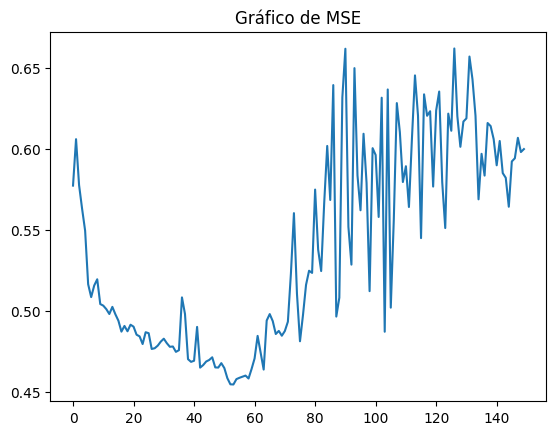

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline


print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.title("Gráfico de MSE")
plt.show()

Juntando tudo, temos:

MSE: 0.62
RMSE: 0.79


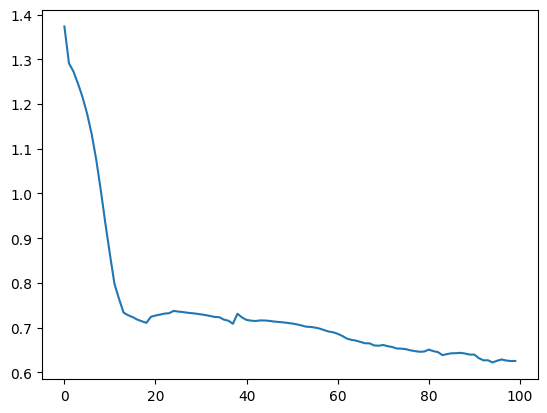

In [26]:
import copy
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
 
# Read data
data = fetch_california_housing()
X, y = data.data, data.target
 
# train-test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
 
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

# Melhorando o modelo com pré-processamento

Acima, você vê que o `RMSE` é `0,68`. De fato, é fácil melhorar o `RMSE` aprimorando os dados antes do treinamento. O problema desse conjunto de dados é a diversidade das feições: algumas são de alcance estreito e outras amplas. E alguns são pequenos, mas positivos, enquanto outros são muito negativos. Isso realmente não é muito bom para a maioria do modelo de aprendizado de máquina.

Uma maneira de melhorar isso é aplicar um `Standard Scaler`. É converter cada feature em sua pontuação padrão. Em outras palavras, para cada recurso, você o substitui por:

$$
Z = \frac{X - \bar{X}}{\sigma_X}
$$

 

Onde:

$\bar{X}$ é a média (`mean`) de $X$ e $\sigma_X$ é o desvio padrão. Desta forma, cada característica transformada é centrada em torno de `0` e em uma faixa estreita que cerca de $70\%$ das amostras estão entre $-1$ a $+1$. Isso pode ajudar o modelo de aprendizado de máquina a convergir.

Você pode aplicar o `Standard Scaler` do scikit-learn. Veja a seguir como você deve modificar a parte de preparação de dados do código acima:

In [27]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
 
# Read data
data = fetch_california_housing()
X, y = data.data, data.target
 
# train-test split for model evaluation
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
 
# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
 
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

Observe que o scaler padrão é aplicado após a divisão do teste de trem. O `StandardScaler` acima é ajustado no conjunto de treinamento, mas aplicado tanto no conjunto de treinamento quanto no de teste. Você não deve aplicar o escalador padrão a todos os dados porque nada do conjunto de teste deve ser sugerido ao modelo. Caso contrário, você está introduzindo vazamento de dados .

Fora isso, praticamente nada será alterado: Você ainda tem 8 recursos (só que não são iguais em valor). Você ainda usa o mesmo loop de treinamento. Se você treinar o modelo com os dados dimensionados, deverá ver o RMSE aprimorado, por exemplo,

MSE: 0.32
RMSE: 0.57


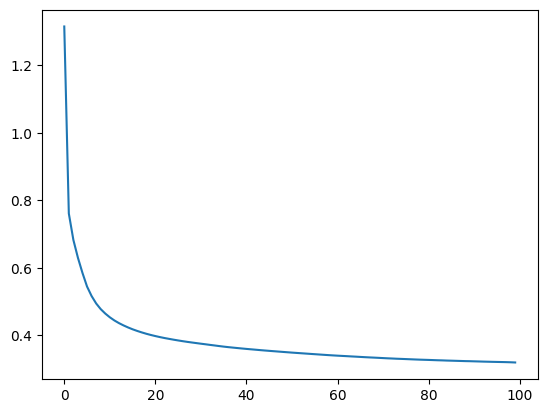

[   2.6288       28.            4.40697674    1.05523256 1011.
    2.93895349   34.04       -118.06      ] -> [1.5125463] (expected [1.603])
[ 2.40530000e+00  2.10000000e+01  4.94513274e+00  1.17168142e+00
  2.23600000e+03  3.95752212e+00  3.69300000e+01 -1.21780000e+02] -> [1.3454462] (expected [1.784])
[ 4.19970000e+00  1.70000000e+01  5.73275862e+00  1.06034483e+00
  2.86600000e+03  3.08836207e+00  3.86600000e+01 -1.21760000e+02] -> [1.5822426] (expected [1.334])
[ 4.80960000e+00  1.60000000e+01  5.51207116e+00  1.03748412e+00
  5.13000000e+03  3.25921220e+00  3.76500000e+01 -1.22460000e+02] -> [2.5094762] (expected [2.62])
[ 1.65050000e+00  5.00000000e+01  3.83876501e+00  1.15437393e+00
  2.24700000e+03  3.85420240e+00  3.40100000e+01 -1.18290000e+02] -> [1.4704301] (expected [1.25])


In [29]:
import copy
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
 
# Read data
data = fetch_california_housing()
X, y = data.data, data.target
 
# train-test split for model evaluation
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
 
# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
 
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()
 
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        print(f"{X_test_raw[i]} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")